In [1]:
import warnings
warnings.filterwarnings('ignore')
import datetime as dt 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, scorer
from matplotlib.colors import ListedColormap
from datetime import timedelta
from scipy import stats

In [2]:
power = pd.read_csv("Data/power_actual.csv")
weather_actuals = pd.read_csv("Data/weather_actuals.csv")
power['datetime'] = pd.to_datetime(power['datetime'])

weather_actuals['datetime'] = pd.to_datetime(weather_actuals['datetime_local'])

power.shape, weather_actuals.shape

((70080, 5), (13619, 32))

# Convert sunrise and sumset to utc time

In [3]:
curr = power['datetime'][0] + timedelta(hours=1) 
curr_day_power = []
avg_power = []
dt = []
for i in range(len(power)):
    curr_day_power.append(power['power'][i])
    
    if power['datetime'][i] == curr:
        dt.append(curr - timedelta(hours=1))
        avg_power.append( sum(curr_day_power) / len(curr_day_power) )
        curr_day_power = []
        curr += timedelta(hours=1)
        
        
    elif power['datetime'][len(power)-1] == power['datetime'][i]:
        dt.append(curr - timedelta(hours=1))
        avg_power.append( sum(curr_day_power) / len(curr_day_power) )
        
          
print(len(avg_power), len(dt))
new_power = pd.DataFrame({'power' : avg_power, 'datetime': dt})
new_power.head()

17520 17520


,power,datetime
0,0.0,2017-10-01 00:00:00
1,0.0,2017-10-01 01:00:00
2,0.0,2017-10-01 02:00:00
3,0.0,2017-10-01 03:00:00
4,0.0,2017-10-01 04:00:00


# Power - Process and visualize the data

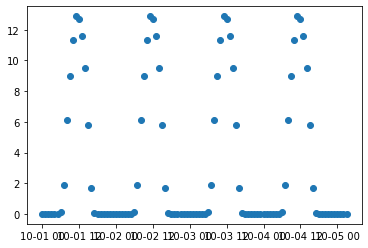

In [4]:
plt.scatter(new_power['datetime'][:100], new_power['power'][:100])
plt.show()

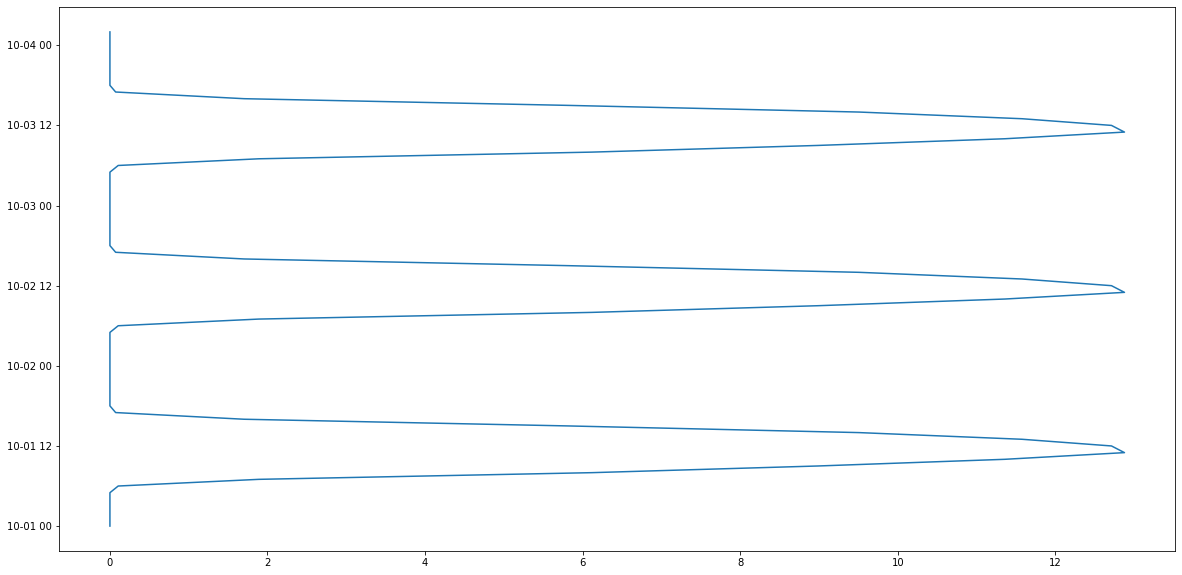

In [5]:
plt.figure(figsize=(20,10))
plt.plot(new_power['power'][:75], new_power['datetime'][:75])

## Keep required values in power

In [6]:
power.isna().sum()

Unnamed: 0        0
datetime          0
ghi           35040
gti           35040
power             0
dtype: int64

In [7]:
power.isnull().sum()

Unnamed: 0        0
datetime          0
ghi           35040
gti           35040
power             0
dtype: int64

In [8]:
power.shape

(70080, 5)

In [9]:
power.describe()

,Unnamed: 0,ghi,gti,power
count,70080.000000,35040.0,35040.0,70080.000000
mean,35039.500000,0.0,0.0,28.612915
std,20230.497769,0.0,0.0,498.795887
min,0.000000,0.0,0.0,0.000000
25%,17519.750000,0.0,0.0,0.000000
50%,35039.500000,0.0,0.0,0.000000
75%,52559.250000,0.0,0.0,5.540000
max,70079.000000,0.0,0.0,16172.040000


### min and max values for ghi and gti are same, so we can drop it and drop Unnamed: 0

Function to drop columns where maximum and minimun number is same

In [10]:
def drop_columns(data):
    for column_name in data:
        if ( data[column_name].dtype in ['int64', 'float64'] ) and ( max(data[column_name]) == min(data[column_name]) ):
            data[column_name].fillna(data[column_name].median())
            if max(data[column_name]) == min(data[column_name]):
                data.drop(column_name, inplace=True, axis=1)
            
    return data

In [11]:
power = drop_columns(power)  
power.drop(columns=['Unnamed: 0'], inplace=True)
power.head()

,datetime,power
0,2017-10-01 00:00:00,0.0
1,2017-10-01 00:15:00,0.0
2,2017-10-01 00:30:00,0.0
3,2017-10-01 00:45:00,0.0
4,2017-10-01 01:00:00,0.0


## The data in power is given for every 15 min, take average of power for each hour

In [12]:
curr = power['datetime'][0] + timedelta(hours=1) 
curr_day_power = []
avg_power = []
dt = []
for i in range(len(power)):
    curr_day_power.append(power['power'][i])
    
    if power['datetime'][i] == curr:
        dt.append(curr - timedelta(hours=1))
        avg_power.append( sum(curr_day_power) / len(curr_day_power) )
        curr_day_power = []
        curr += timedelta(hours=1)
        
        
    elif power['datetime'][len(power)-1] == power['datetime'][i]:
        dt.append(curr - timedelta(hours=1))
        avg_power.append( sum(curr_day_power) / len(curr_day_power) )
        
          
print(len(avg_power), len(dt))
new_power = pd.DataFrame({'power' : avg_power, 'datetime': dt})
new_power.head()

17520 17520


,power,datetime
0,0.0,2017-10-01 00:00:00
1,0.0,2017-10-01 01:00:00
2,0.0,2017-10-01 02:00:00
3,0.0,2017-10-01 03:00:00
4,0.0,2017-10-01 04:00:00


In [13]:
new_power.shape

(17520, 2)

# Weather_actual - training - Process the data

### Convert local time to utc time, to make sence of sunrise and sunset time

In [14]:
weather_actuals['datetime'] = pd.to_datetime(weather_actuals['datetime_local'])
weather_actuals['datetime_utc'] = pd.to_datetime(weather_actuals['datetime_utc'])
weather_actuals['sunrise'] = pd.to_datetime(weather_actuals['sunrise']) + pd.DateOffset(hours=5,minutes=30,seconds=0)
weather_actuals['sunset'] = pd.to_datetime(weather_actuals['sunset'])+ pd.DateOffset(hours=5,minutes=30,seconds=0)

In [16]:
weather_actuals.describe()

,Unnamed: 0,plant_id,cloud_cover,apparent_temperature,temperature,humidity,dew_point,wind_bearing,wind_speed,wind_chill,...,qpf,uv_index,snow,pop,fctcode,ozone,precip_accumulation,precip_intensity,precip_probability,visibility
count,13619.000000,13619.0,13619.000000,13619.000000,13619.000000,13619.000000,13619.000000,13619.000000,13619.000000,3744.0,...,3744.0,13619.000000,3744.0,3744.0,3744.0,13619.000000,3744.0,13619.000000,13619.000000,13619.000000
mean,6809.000000,1.0,-314.005310,25.944639,24.498054,0.537411,11.924626,-498.677363,-540.808704,-9999.0,...,-9999.0,-2394.989280,-9999.0,-9999.0,-9999.0,-2187.730797,-9999.0,-2396.367775,-2396.398081,-117.086149
std,3931.610993,0.0,1744.610028,10.469808,8.840016,0.498617,9.129459,2557.943872,2267.247300,0.0,...,0.0,4269.320576,0.0,0.0,0.0,4385.706548,0.0,4268.545854,4268.528833,1130.763316
min,0.000000,1.0,-9999.000000,3.140000,5.000000,0.000000,-20.560000,-9999.000000,-9999.000000,-9999.0,...,-9999.0,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.000000
25%,3404.500000,1.0,0.000000,17.310000,17.000000,0.000000,5.920000,79.000000,1.620000,-9999.0,...,-9999.0,0.000000,-9999.0,-9999.0,-9999.0,236.900000,-9999.0,0.000000,0.000000,3.540000
50%,6809.000000,1.0,0.000000,25.540000,25.000000,1.000000,10.710000,149.000000,2.410000,-9999.0,...,-9999.0,0.000000,-9999.0,-9999.0,-9999.0,270.800000,-9999.0,0.000000,0.000000,16.090000
75%,10213.500000,1.0,0.410000,34.580000,31.000000,1.000000,19.670000,293.000000,3.330000,-9999.0,...,-9999.0,2.000000,-9999.0,-9999.0,-9999.0,280.800000,-9999.0,0.000000,0.000000,16.090000
max,13618.000000,1.0,1.000000,49.750000,47.000000,1.000000,28.350000,359.000000,9.730000,-9999.0,...,-9999.0,12.000000,-9999.0,-9999.0,-9999.0,351.700000,-9999.0,6.220000,0.730000,16.090000


In [17]:
cols =['snow','wind_chill','pop','fctcode','heat_index','precip_accumulation','qpf','precip_type','humidity','summary','uv_index','icon']
weather_actuals[cols]=weather_actuals[cols].fillna(weather_actuals[cols].mode().iloc[0])

# Merge Data

In [19]:
train_data = pd.merge(new_power, weather_actuals, on='datetime')
train_data.shape

train_data.drop(columns=['Unnamed: 0', 'updated_at'], inplace=True)

label = pd.DataFrame()
label['power'] = train_data['power']
train_data = train_data.drop(columns=['power'])
train_data.shape, label.shape

((13619, 30), (13619, 1))

# Handel datetime data

In [20]:
train_data['hour'] = pd.DatetimeIndex(train_data['datetime_utc']).hour
train_data['month'] = pd.DatetimeIndex(train_data['datetime_utc']).month
train_data['year'] = pd.DatetimeIndex(train_data['datetime_utc']).year

train_data['sunrise_year'] = pd.DatetimeIndex(train_data['sunrise']).year
train_data['sunrise_month'] = pd.DatetimeIndex(train_data['sunrise']).month
train_data['sunrise_day'] = pd.DatetimeIndex(train_data['sunrise']).day
train_data['sunrise_hour'] = pd.DatetimeIndex(train_data['sunrise']).hour
train_data['sunrise_min'] = pd.DatetimeIndex(train_data['sunrise']).minute
train_data['sunrise_sec'] = pd.DatetimeIndex(train_data['sunrise']).second

train_data['sunset_year'] = pd.DatetimeIndex(train_data['sunset']).year
train_data['sunset_month'] = pd.DatetimeIndex(train_data['sunset']).month
train_data['sunset_day'] = pd.DatetimeIndex(train_data['sunset']).day
train_data['sunset_hour'] = pd.DatetimeIndex(train_data['sunset']).hour
train_data['sunset_min'] = pd.DatetimeIndex(train_data['sunset']).minute
train_data['sunset_sec'] = pd.DatetimeIndex(train_data['sunset']).second

train_data.drop(columns=['datetime','datetime_utc','sunrise', 'sunset', 'datetime_local'], inplace=True)
train_data.shape

(13619, 40)

# Remove Outliers

In [21]:
q1 = train_data.quantile(0.25)
q3 = train_data.quantile(0.75)
iqr = q3 - q1
# iqr

In [22]:
def remove_outliers(col):
    q1 = col.quantile(0.10)
    q4 = col.quantile(0.90)
    
    col = np.where(col < q1, q1, col)
    col = np.where(col > q4, q4, col)

    return col

train_data['wind_bearing'] = remove_outliers(train_data['wind_bearing'])
train_data.shape

(13619, 40)

train_data.isna().sum()

In [23]:
categorical_columns = ['icon','summary', 'precip_type']

# Standardize the data

In [24]:
from sklearn.preprocessing import StandardScaler
data = train_data.drop(columns=categorical_columns)
print(data.shape)
scaler = StandardScaler()
scaler.fit(data)
columns = data.columns
data = pd.DataFrame(data = scaler.transform(data), columns = columns)
train_data = pd.concat([data, train_data[categorical_columns]], axis=1, sort=False)
train_data.shape

(13619, 37)


(13619, 40)

In [25]:
categorical_columns = ['icon','summary', 'precip_type']

train_data = pd.get_dummies(train_data, columns=categorical_columns)

# Model Training

In [26]:
from sklearn.model_selection import train_test_split
X = train_data
y = label['power']
print(X.shape, y.shape)
x_train, x_test, y_train, y_test = train_test_split(train_data, y.values, test_size=0.2, random_state=42)

(13619, 66) (13619,)


In [49]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=200, max_depth=300)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

regressor.score(x_train,y_train), regressor.score(x_test,y_test)

Mean Absolute Error: 47.89512028726139
Mean Squared Error: 237345.79752254058
Root Mean Squared Error: 487.1814831482623


(0.935935644520237, 0.6118389377582958)

# Predict the power for test data

In [36]:
test_data = pd.read_csv("Data/weather_forecast.csv")

test_data.drop(columns=['Unnamed: 0'], inplace=True)
test_data['datetime'] = pd.to_datetime(test_data['datetime_local'])
test_data['datetime_utc'] = pd.to_datetime(test_data['datetime_utc'])
test_data['sunrise'] = pd.to_datetime(test_data['sunrise']) + pd.DateOffset(hours=5,minutes=30,seconds=0)
test_data['sunset'] = pd.to_datetime(test_data['sunset'])+ pd.DateOffset(hours=5,minutes=30,seconds=0)

test_data['hour'] = pd.DatetimeIndex(test_data['datetime_utc']).hour
test_data['month'] = pd.DatetimeIndex(test_data['datetime_utc']).month
test_data['year'] = pd.DatetimeIndex(test_data['datetime_utc']).year

test_data['sunrise_year'] = pd.DatetimeIndex(test_data['sunrise']).year
test_data['sunrise_month'] = pd.DatetimeIndex(test_data['sunrise']).month
test_data['sunrise_day'] = pd.DatetimeIndex(test_data['sunrise']).day
test_data['sunrise_hour'] = pd.DatetimeIndex(test_data['sunrise']).hour
test_data['sunrise_min'] = pd.DatetimeIndex(test_data['sunrise']).minute
test_data['sunrise_sec'] = pd.DatetimeIndex(test_data['sunrise']).second

test_data['sunset_year'] = pd.DatetimeIndex(test_data['sunset']).year
test_data['sunset_month'] = pd.DatetimeIndex(test_data['sunset']).month
test_data['sunset_day'] = pd.DatetimeIndex(test_data['sunset']).day
test_data['sunset_hour'] = pd.DatetimeIndex(test_data['sunset']).hour
test_data['sunset_min'] = pd.DatetimeIndex(test_data['sunset']).minute
test_data['sunset_sec'] = pd.DatetimeIndex(test_data['sunset']).second

test_data.drop(columns=['plant_id', 'datetime_utc', 'datetime', 'sunrise', 'sunset', 'updated_at', 'datetime_local'], inplace=True)
test_data.columns

Index(['cloud_cover', 'apparent_temperature', 'temperature', 'humidity',
       'dew_point', 'wind_bearing', 'wind_speed', 'wind_chill', 'wind_gust',
       'heat_index', 'pressure', 'qpf', 'uv_index', 'snow', 'pop', 'fctcode',
       'ozone', 'precip_accumulation', 'precip_intensity',
       'precip_probability', 'precip_type', 'visibility', 'icon', 'summary',
       'hour', 'month', 'year', 'sunrise_year', 'sunrise_month', 'sunrise_day',
       'sunrise_hour', 'sunrise_min', 'sunrise_sec', 'sunset_year',
       'sunset_month', 'sunset_day', 'sunset_hour', 'sunset_min',
       'sunset_sec'],
      dtype='object')

In [37]:
cols =['snow','wind_chill','pop','fctcode','heat_index','precip_accumulation','qpf','precip_type','humidity','summary','uv_index','icon']
test_data[cols]= test_data[cols].fillna(weather_actuals[cols].mode().iloc[0])

In [38]:
q1 = test_data.quantile(0.25)
q3 = test_data.quantile(0.75)
iqr = q3 - q1
iqr

cloud_cover               0.1100
apparent_temperature      8.1250
temperature               8.0000
humidity                  1.0000
dew_point                 4.5625
wind_bearing            221.7500
wind_speed                0.9825
wind_chill                0.0000
wind_gust                 1.6800
heat_index                0.0000
pressure                  2.5125
qpf                       0.0000
uv_index                  3.0000
snow                      0.0000
pop                       0.0000
fctcode                   0.0000
ozone                     3.3000
precip_accumulation       0.0000
precip_intensity          0.0000
precip_probability        0.0000
visibility                0.0000
hour                     11.5000
month                     0.0000
year                      0.0000
sunrise_year              0.0000
sunrise_month             0.0000
sunrise_day              14.0000
sunrise_hour              0.0000
sunrise_min               8.0000
sunrise_sec              31.0000
sunset_yea

In [39]:
test_data['wind_bearing'] = remove_outliers(test_data['wind_bearing'])

In [40]:
scaler.fit(data)
columns = data.columns
data = pd.DataFrame(data = scaler.transform(data), columns = columns)
test_data = pd.concat([data, test_data[categorical_columns]], axis=1, sort=False)
test_data.shape

(13619, 40)

In [41]:
test_data = pd.get_dummies(test_data, columns=['icon','summary', 'precip_type'])
test_data.shape

(13619, 48)

In [42]:
reamining_col = [i for i in train_data if i not in test_data.columns]
test_data[reamining_col]= train_data[reamining_col]

Index(['plant_id', 'cloud_cover', 'apparent_temperature', 'temperature',
       'humidity', 'dew_point', 'wind_bearing', 'wind_speed', 'wind_chill',
       'wind_gust', 'heat_index', 'pressure', 'qpf', 'uv_index', 'snow', 'pop',
       'fctcode', 'ozone', 'precip_accumulation', 'precip_intensity',
       'precip_probability', 'visibility', 'hour', 'month', 'year',
       'sunrise_year', 'sunrise_month', 'sunrise_day', 'sunrise_hour',
       'sunrise_min', 'sunrise_sec', 'sunset_year', 'sunset_month',
       'sunset_day', 'sunset_hour', 'sunset_min', 'sunset_sec',
       'icon_clear-day', 'icon_clear-night', 'icon_cloudy',
       'icon_partly-cloudy-day', 'icon_partly-cloudy-night', 'summary_Clear',
       'summary_Humid and Mostly Cloudy', 'summary_Mostly Cloudy',
       'summary_Overcast', 'summary_Partly Cloudy', 'precip_type_rain',
       'icon_fog', 'icon_rain', 'icon_wind', 'summary_Breezy and Foggy',
       'summary_Foggy', 'summary_Humid', 'summary_Humid and Foggy',
       'summ

In [43]:
y_pred1 = regressor.predict(test_data)

In [45]:
y_pred1

array([0., 0., 0., ..., 0., 0., 0.])

In [48]:
pd.DataFrame(y_pred1).to_csv("final_power.csv")